In [1]:
import pickle
import math
import random

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import imp
import functions

from joblib import Parallel, delayed
from sklearn.manifold import TSNE
import datetime as dt

from web_crawler import grabDomainRoot

def padInput(input):
    max_length = np.max([len(i) for i in input])
    input_size = len(input)
    input_pad = np.zeros((input_size, max_length))
    
    for idx_row, row in enumerate(input):
        for idx_col, col in enumerate(row):
            input_pad[idx_row][idx_col]=col
            
    return input_pad

karate_club = [[2, 1],
[3, 1], [3, 2],
[4, 1], [4, 2], [4, 3],
[5, 1],
[6, 1],
[7, 1], [7, 5], [7, 6],
[8, 1], [8, 2], [8, 3], [8, 4],
[9, 1], [9, 3],
[10, 3],
[11, 1], [11, 5], [11, 6],
[12, 1],
[13, 1], [13, 4],
[14, 1], [14, 2], [14, 3], [14, 4],
[17, 6], [17, 7],
[18, 1], [18, 2],
[20, 1], [20, 2],
[22, 1], [22, 2],
[26, 24], [26, 25],
[28, 3], [28, 24], [28, 25],
[29, 3],
[30, 24], [30, 27],
[31, 2], [31, 9],
[32, 1], [32, 25], [32, 26], [32, 29],
[33, 3], [33, 9], [33, 15], [33, 16], [33, 19], [33, 21], [33, 23], [33, 24], [33, 30], [33, 31], [33, 32],
[34, 9], [34, 10], [34, 14], [34, 15], [34, 16], [34, 19], [34, 20], [34, 21], [34, 23], [34, 24], [34, 27],
               [34, 28], [34, 29], [34, 30], [34, 31], [34, 32], [34, 33],]

In [2]:
dummy_graph = [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], 
              [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6]]

In [3]:
karate_club = [[karate_club[idx][0]-1,karate_club[idx][1]-1] for idx in range(len(karate_club))]

In [4]:
#graph = pickle.load(open('backup/graph_root_sina.pkl', 'rb'))
#domains = pickle.load(open('backup/domains_root_sina.pkl', 'rb'))
graph_file = pickle.load(open('crawler_results/graph_calls_620000_stack_test.pkl', 'rb'))
#domains_file = pickle.load(open('domains_calls_1000', 'rb'))
#graph = karate_club
#graph = dummy_graph

In [5]:
key_domain_dict = {}
unique_keys = set([])
for key in graph_file.keys():
    keys = [graph_file[key][idx] for idx in range(0, len(graph_file[key]), 3)]
    #domain = graph_file[key][1]
    #key_domain_dict[key] = domain
    unique_keys = unique_keys.union(keys)

unique_keys = unique_keys | set(graph_file.keys())

In [6]:
len(unique_keys)

93288

In [7]:
key_domain_dict = {i:grabDomainRoot(i) for i in unique_keys}

NO BASE URL
NO BASE URL
NO BASE URL


In [8]:
domain_dict = {i:idx for idx, i in enumerate(set(key_domain_dict.values()))}

In [9]:
len(domain_dict)

8973

In [10]:
vocab_dict = {key:idx for idx, key in enumerate(unique_keys)}
inv_map = {values:keys for keys, values in vocab_dict.items()}

In [11]:
#web_graph = nx.DiGraph()
web_graph = nx.Graph()
for node in graph_file.keys():
    for idx in range(0, len(graph_file[node]), 3):
        key = graph_file[node][idx]
        #print (key)
        web_graph.add_edge(vocab_dict[node], vocab_dict[key])

In [12]:
list_of_nodes = [i for i in web_graph.nodes()]

In [13]:
print(len(list_of_nodes), len(vocab_dict), len(key_domain_dict))

93288 93288 93288


In [49]:
#for connection in graph:
#    web_graph.add_edge(connection[0], connection[1])

In [50]:
plt.figure(figsize=(10, 10))
nx.draw(web_graph, node_size=100)#, with_labels=True)
plt.savefig('nytimes_root_graph_undirected.png')
#plt.show()

In [14]:
def randomWalk(graph, initial_node, step, max_step, path):
 
    if step>= max_step: 
        return path
    
    adjacent_nodes = [i for i in graph[initial_node]]
    
    next_node = random.sample(adjacent_nodes, 1)[0]
    
    path.append(next_node)
    
    return randomWalk(graph, next_node, step+1, max_step, path)

In [15]:
def generateBatchKuhan(batch_size, num_context_per_label, context_window, target, step):

    batch = []
    passes_through_batch = batch_size//num_context_per_label
    
    for window_idx in range(passes_through_batch): #double / gives you a integer

        current_window = list(context_window[window_idx + passes_through_batch*step])
        current_target = target[window_idx + passes_through_batch*step]
        context_samples = random.sample(current_window, num_context_per_label)
        data_samples =  [[context_sample, [current_target]] for context_sample in context_samples]

        for data_sample in data_samples:
            batch.append(data_sample)
            
    return batch

In [16]:
max_step = 2 #Window size and max_step must be connected

num_skips = 1 #The number of context examples per label to create x-y data out of 
#i.e. the number of rows of "data" per window, label combo
window_size = max_step//2 #where max step must be even
embedding_size = 32  #Dimension of the embedding vector.
vocabulary_size = len(web_graph.nodes())

num_sampled = 64 #Number of negative examples to sample. 
#As this number goes to the total number of samples it reproduces softmax, 
#this not quite correct as we still doing binary classification, except now we give every negative example to test against,
#as opposed to true multi-class classification
batch_size = 64 #must be a multiple of num_skips
num_steps = int(len(list_of_nodes)/batch_size)
n_epochs = 10000 #This controls the number of walks from each node

In [18]:
print (len(list_of_nodes), num_steps, vocabulary_size)

93288 1457 93288


In [19]:
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    # Ops and variables pinned to the CPU because of missing GPU implementation
    #with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm

In [20]:
#For sanity checking
#batch_inputs = [2, 2, 0, 0, 13, 15, 7, 8, 9, 10, 11, 14, 6, 6, 1, 1]
#batch_labels = [[3], [3], [13], [0], [15], [11], [15], [13], [14], [2], [7], [8], [3], [3], [3], [3]]

In [21]:
avg_loss_record = []
list_batch_labels = []
list_batch_inputs = []

with tf.Session(graph=graph) as session:

    # We must initialize all variables before we use them.
    session.run(tf.global_variables_initializer())
    print('Initialized')

    average_loss = 0

    for epoch in range(n_epochs):
        #Conduct shuffle the list of nodes at the start of each epoch
        random.shuffle(list_of_nodes)
        random_walks = []
        
        for node in list_of_nodes:
            #Step through each node and conduct a random walk about it of length max_step
            path = randomWalk(web_graph, node, 0, max_step, [node])
            random_walks.append(path)
        
        data_windows = np.array(random_walks)

        target = data_windows[:,window_size]

        left_window = data_windows[:,:window_size]

        right_window = data_windows[:,window_size+1:]

        context_window = np.concatenate([left_window, right_window], axis=1)
            
        for step in range(num_steps):
        #for step in range(16):

            batch_data = generateBatchKuhan(batch_size, num_skips, context_window, target, step)
            batch_inputs = [row[0] for row in batch_data]
            batch_labels = [row[1] for row in batch_data]
            
            #batch_inputs = [row for row in range(batch_size)]
            #batch_labels = [[row] for row in range(batch_size)]
            #print (batch_inputs, batch_labels)
            
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
            list_batch_labels.append([batch_labels])
            list_batch_inputs.append([batch_inputs])
            
            _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
            
            average_loss += loss_val
            
            #if step%15==0:
            #    print (step, loss_val, num_steps)

        #if epoch!=0: average_loss /= num_steps #This is the averaged over the steps, this means data is passed through only once?
        #I think because num_steps> length of data, we must recycle through the data set
        #but each time data is randomly generated, because we are using different context words

        if epoch%1==0: 
            
            avg_loss_record.append(float(average_loss)/num_steps)
            print('epoch:%d, Average loss:%.7g' % (epoch, float(average_loss)/num_steps))
        
        average_loss = 0

        final_embeddings = normalized_embeddings.eval()

Initialized
epoch:0, Average loss:255.3678
epoch:1, Average loss:227.3674
epoch:2, Average loss:212.1699
epoch:3, Average loss:201.6678
epoch:4, Average loss:193.2812
epoch:5, Average loss:187.6954
epoch:6, Average loss:183.7282
epoch:7, Average loss:176.8307
epoch:8, Average loss:172.5538
epoch:9, Average loss:168.0519
epoch:10, Average loss:163.4501
epoch:11, Average loss:161.9577
epoch:12, Average loss:158.2213
epoch:13, Average loss:156.2043
epoch:14, Average loss:152.8279
epoch:15, Average loss:151.4533
epoch:16, Average loss:147.7176
epoch:17, Average loss:146.4816
epoch:18, Average loss:145.3305
epoch:19, Average loss:140.5006
epoch:20, Average loss:139.2169
epoch:21, Average loss:137.767
epoch:22, Average loss:134.8996
epoch:23, Average loss:133.8367
epoch:24, Average loss:133.5081
epoch:25, Average loss:130.7004
epoch:26, Average loss:129.263
epoch:27, Average loss:127.9978
epoch:28, Average loss:126.3672
epoch:29, Average loss:124.7209
epoch:30, Average loss:124.1078
epoch:31

epoch:253, Average loss:1.873717
epoch:254, Average loss:1.751584
epoch:255, Average loss:1.778047
epoch:256, Average loss:1.77502
epoch:257, Average loss:1.750901
epoch:258, Average loss:1.72242
epoch:259, Average loss:1.706749
epoch:260, Average loss:1.736184
epoch:261, Average loss:1.718657
epoch:262, Average loss:1.694777
epoch:263, Average loss:1.67095
epoch:264, Average loss:1.675901
epoch:265, Average loss:1.634412
epoch:266, Average loss:1.580471
epoch:267, Average loss:1.610569
epoch:268, Average loss:1.622351
epoch:269, Average loss:1.633849
epoch:270, Average loss:1.597549
epoch:271, Average loss:1.584195
epoch:272, Average loss:1.518142
epoch:273, Average loss:1.538894
epoch:274, Average loss:1.545139
epoch:275, Average loss:1.553237
epoch:276, Average loss:1.557053
epoch:277, Average loss:1.53028
epoch:278, Average loss:1.525853
epoch:279, Average loss:1.480379
epoch:280, Average loss:1.524366
epoch:281, Average loss:1.464237
epoch:282, Average loss:1.438546
epoch:283, Ave

epoch:501, Average loss:0.9486672
epoch:502, Average loss:0.9245638
epoch:503, Average loss:0.9207603
epoch:504, Average loss:0.897547
epoch:505, Average loss:0.9274733
epoch:506, Average loss:0.9232293
epoch:507, Average loss:0.9121817
epoch:508, Average loss:0.9089232
epoch:509, Average loss:0.9165873
epoch:510, Average loss:0.9159574
epoch:511, Average loss:0.9629664
epoch:512, Average loss:0.9049002
epoch:513, Average loss:0.9266745
epoch:514, Average loss:0.8899802
epoch:515, Average loss:0.9051166
epoch:516, Average loss:0.8833465
epoch:517, Average loss:0.9368264
epoch:518, Average loss:0.9220618
epoch:519, Average loss:0.8881922
epoch:520, Average loss:0.8971819
epoch:521, Average loss:0.9342029
epoch:522, Average loss:0.9163223
epoch:523, Average loss:0.8632777
epoch:524, Average loss:0.9002733
epoch:525, Average loss:0.9551629
epoch:526, Average loss:0.9001743
epoch:527, Average loss:0.8934812
epoch:528, Average loss:0.8754737
epoch:529, Average loss:0.8726705
epoch:530, Aver

epoch:743, Average loss:0.7371677
epoch:744, Average loss:0.7298507
epoch:745, Average loss:0.7579121
epoch:746, Average loss:0.7577173
epoch:747, Average loss:0.7557689
epoch:748, Average loss:0.7673514
epoch:749, Average loss:0.7398753
epoch:750, Average loss:0.7176111
epoch:751, Average loss:0.7178176
epoch:752, Average loss:0.7478573
epoch:753, Average loss:0.7668689
epoch:754, Average loss:0.7349555
epoch:755, Average loss:0.7223956
epoch:756, Average loss:0.7171186
epoch:757, Average loss:0.7441568
epoch:758, Average loss:0.760429
epoch:759, Average loss:0.7242564
epoch:760, Average loss:0.7452032
epoch:761, Average loss:0.7471186
epoch:762, Average loss:0.7390444
epoch:763, Average loss:0.7138965
epoch:764, Average loss:0.7075683
epoch:765, Average loss:0.7576869
epoch:766, Average loss:0.7449909
epoch:767, Average loss:0.6831991
epoch:768, Average loss:0.7197239
epoch:769, Average loss:0.7210554
epoch:770, Average loss:0.7369751
epoch:771, Average loss:0.7276542
epoch:772, Aver

epoch:985, Average loss:0.6149767
epoch:986, Average loss:0.63807
epoch:987, Average loss:0.5879375
epoch:988, Average loss:0.6081936
epoch:989, Average loss:0.6128467
epoch:990, Average loss:0.6070143
epoch:991, Average loss:0.6439362
epoch:992, Average loss:0.5997353
epoch:993, Average loss:0.6017034
epoch:994, Average loss:0.603451
epoch:995, Average loss:0.6005278
epoch:996, Average loss:0.6053778
epoch:997, Average loss:0.5822153
epoch:998, Average loss:0.5928734
epoch:999, Average loss:0.6063943
epoch:1000, Average loss:0.5828765
epoch:1001, Average loss:0.6223346
epoch:1002, Average loss:0.5957019
epoch:1003, Average loss:0.5781362
epoch:1004, Average loss:0.5884078
epoch:1005, Average loss:0.6338752
epoch:1006, Average loss:0.6024599
epoch:1007, Average loss:0.5915515
epoch:1008, Average loss:0.6196332
epoch:1009, Average loss:0.6142413
epoch:1010, Average loss:0.5959617


KeyboardInterrupt: 

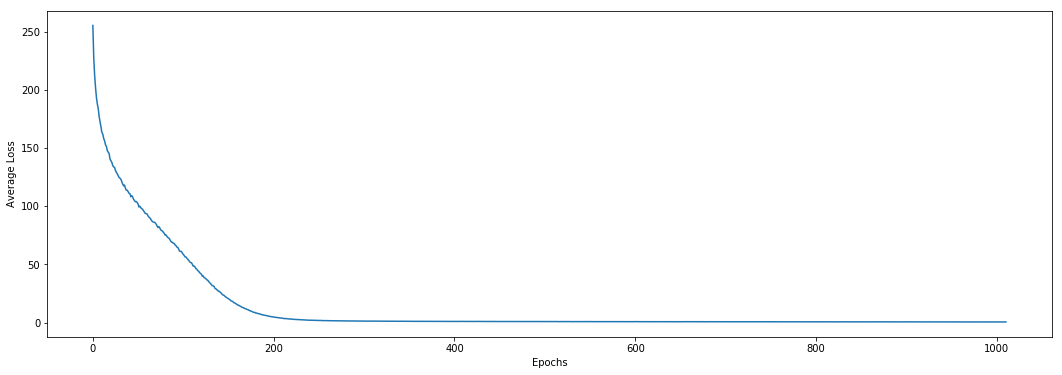

In [22]:
list_loss = np.array(avg_loss_record)
plt.figure(figsize=(18, 6))
plt.plot([i for 
          i in range(len(list_loss))], list_loss)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

In [23]:
#tf.reset_default_graph()

In [24]:
vector = tf.placeholder(dtype=tf.float32)
#Create similarity matrix
mult_vector = tf.matmul(vector, vector, transpose_b=True)
sim_matrix = tf.acos(mult_vector)

In [25]:
with tf.Session() as sess:
    matrices = sess.run([sim_matrix, mult_vector] , feed_dict={vector:final_embeddings})

ResourceExhaustedError: OOM when allocating tensor with shape[93288,93288]
	 [[Node: MatMul = BatchMatMul[T=DT_FLOAT, adj_x=false, adj_y=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_Placeholder_0_0/_1, _arg_Placeholder_0_0/_1)]]

Caused by op 'MatMul', defined at:
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-20a73dece171>", line 3, in <module>
    mult_vector = tf.matmul(vector, vector, transpose_b=True)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1814, in matmul
    a, b, adj_x=adjoint_a, adj_y=adjoint_b, name=name)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 337, in _batch_mat_mul
    adj_y=adj_y, name=name)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[93288,93288]
	 [[Node: MatMul = BatchMatMul[T=DT_FLOAT, adj_x=false, adj_y=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_Placeholder_0_0/_1, _arg_Placeholder_0_0/_1)]]


In [ ]:
sim_matrix = matrices[0]

In [30]:
sim_matrix = np.array([[value if value==value else 0 for value in row] for row in sim_matrix])

TypeError: 'Tensor' object is not iterable.

In [ ]:
np.fill_diagonal(sim_matrix, 0)

In [ ]:
#Similarity is based  on the batch inputs not on the batch labels!
#This is important
#batch_inputs

In [ ]:
results = []
for idx_row, row in enumerate(sim_matrix):
    #print (row)
    top_n_scores = [row[i] for i in np.argsort(row)[:2]]
    top_n_nodes = [i for i in np.argsort(row)[:2]]
    results.append([top_n_scores[1], top_n_nodes[1]])

In [ ]:
results = np.array(results)

In [ ]:
np.argsort(results[:,0])

In [29]:
results[1198]

NameError: name 'results' is not defined

In [27]:
sim = sim_matrix[1198]

top_n_scores = [sim[i] for i in np.argsort(sim)[:5]]
top_n_nodes = [i for i in np.argsort(sim)[:5]]

bottom_n_scores = [sim[i] for i in np.argsort(sim)[-5:]]
bottom_n_nodes = [i for i in np.argsort(sim)[-5:]]

top_n_scores, top_n_nodes, bottom_n_scores, bottom_n_nodes

([<tf.Tensor 'strided_slice_1:0' shape=<unknown> dtype=float32>],
 [0],
 [<tf.Tensor 'strided_slice_2:0' shape=<unknown> dtype=float32>],
 [0])

In [28]:
[inv_map[i] for i in bottom_n_nodes]

['https://create.adobe.com/2017/10/17/german_gonzalez_artist_of_the_portrait.html']

In [88]:
#FIGURE OUT WHY THESE TWO ARE NOT SIMILAR
vocab_dict['https://support.google.com/a/answer/60217'], vocab_dict['https://support.google.com/a/answer/48323']

(8, 1670)

In [104]:
len(sim_matrix)

2861

In [302]:
learning_grid = [1]
perplexity_grid = [50]

for learning_rate in learning_grid:
    for perplexity in perplexity_grid:
        tsne = TSNE(perplexity=perplexity, n_components=2, learning_rate=learning_rate, n_iter=20000, 
                    verbose=9, metric='precomputed', method='exact')
        
        low_dim_embs = tsne.fit_transform(sim_matrix)
        pickle.dump(low_dim_embs, open('low_dim_embs_grid_%d_%d.pkl' % (learning_rate, perplexity), 'wb'))

[t-SNE] Computed conditional probabilities for sample 1000 / 2861
[t-SNE] Computed conditional probabilities for sample 2000 / 2861
[t-SNE] Computed conditional probabilities for sample 2861 / 2861
[t-SNE] Mean sigma: 0.194473
[t-SNE] Iteration 50: error = 77.0252699, gradient norm = 0.0000004 (50 iterations in 19.964s)
[t-SNE] Iteration 100: error = 77.0252699, gradient norm = 0.0000000 (50 iterations in 19.918s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 77.025270
[t-SNE] Iteration 150: error = 3.9338658, gradient norm = 0.0000000 (50 iterations in 19.841s)
[t-SNE] Iteration 150: gradient norm 0.000000. Finished.
[t-SNE] Error after 150 iterations: 3.933866


In [83]:
pickle.dump(low_dim_embs, open('low_dim_embs_25_50.pkl', 'wb'))

In [167]:
low_dim_embs = pickle.load(open('low_dim_embs_25_50.pkl', 'rb'))

In [225]:
low_dim_embs

array([[ -7.90036438e-07,   1.75484047e-06],
       [ -7.90507670e-07,   1.98604312e-06],
       [ -8.42996030e-07,   1.73647913e-06],
       ..., 
       [ -8.43086980e-07,   1.72284467e-06],
       [ -8.17290015e-07,   1.62007120e-06],
       [ -7.85204691e-07,   1.71774923e-06]], dtype=float32)

In [169]:
%matplotlib notebook
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

In [170]:
import pandas as pd

In [205]:
df_domain_freq = pd.DataFrame(list(zip(*np.unique([i for i in key_domain_dict.values()], return_counts=True))), 
                             columns=['domain', 'freq'])

In [206]:
def parseDomain(string):
    try: 
        results = string.split('.')
        if len(results)==3: return results[1]
        else: return string
    except:
        return string

In [207]:
df_domain_freq['domain_short'] = df_domain_freq['domain'].apply(parseDomain)

In [274]:
df_domain_freq = df_domain_freq.groupby(['domain_short'])['freq'].sum().reset_index()

In [275]:
df_domain_freq[df_domain_freq['freq']>100]

,domain_short,freq
7,apple,360
26,facebook,386
39,google,406
85,twitter,1113
86,twitter.com,192


In [253]:
frequent_domains = df_domain_freq[df_domain_freq['freq']>100]

In [267]:
frequent_domain_dict = {i:idx for idx, i in enumerate(frequent_domains['domain_short'].values)} 

In [268]:
frequent_domain_dict['other'] = len(frequent_domain_dict)

In [281]:
frequent_domain_inv_dict = {value:key for key, value in frequent_domain_dict.items()}

In [277]:
labels_str = []
for i in range(0, len(web_graph.nodes()), 1):
    domain = key_domain_dict[inv_map[i]]
    labels_str.append('other')
    for root in frequent_domain_dict.keys():
        if root in domain:
            labels_str.append(root)
            break

In [284]:
frequent_domain_inv_dict

{0: 'apple',
 1: 'facebook',
 2: 'google',
 3: 'twitter',
 4: 'twitter.com',
 5: 'other'}

In [285]:
labels = [frequent_domain_dict[i] for i in labels_str]

#pickle.dump(low_dim_embs, open('low_dim_embs.pkl', 'wb'))

#low_dim_embs = pickle.load(open('low_dim_embs_grid_1_5.pkl', 'rb'))

In [287]:
filtered_embeddings = []
filtered_labels_str = []
filtered_labels = []
for idx, embed in enumerate(low_dim_embs):
    if labels_str[idx]!='other':
        filtered_embeddings.append(embed)
        filtered_labels_str.append(labels_str[idx])
        filtered_labels.append(labels[idx])

In [289]:
import matplotlib
import matplotlib.cm as cm

In [290]:
minima = min(filtered_labels)
maxima = max(filtered_labels)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.rainbow)

In [291]:
color_map = [mapper.to_rgba(v) for v in filtered_labels]

In [295]:
filtered_embeddings.shape

(1337, 2)

In [293]:
filtered_embeddings = np.array(filtered_embeddings)

<IPython.core.display.Javascript object>


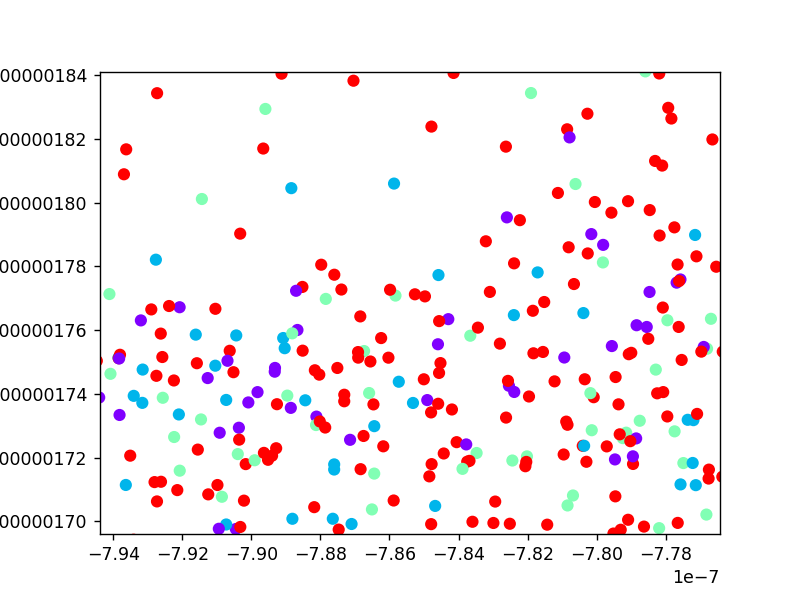

In [294]:
plt.figure()
plt.scatter(filtered_embeddings[:,0], filtered_embeddings[:,1], color=color_map)
plt.show()

<IPython.core.display.Javascript object>


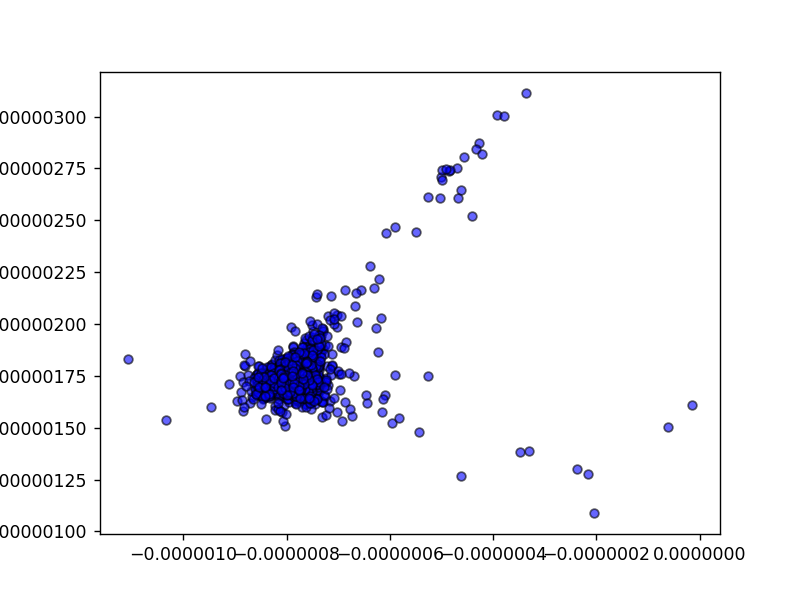

In [298]:
learning_grid = [25]
perplexity_grid = [100]
for learning_rate in learning_grid:
    for perplexity in perplexity_grid:
        #low_dim_embs = pickle.load(open('low_dim_embs_grid_%d_%d.pkl' % (learning_rate, perplexity), 'rb'))
        
        fig, ax = plt.subplots()

        points = ax.plot(filtered_embeddings[:,0], filtered_embeddings[:,1], 'o', color='b',
                     mec='k', ms=5, mew=1, alpha=.6)
        fig.savefig('low_dim_embs_grid_%d_%d.png' % (learning_rate, perplexity))

tooltip = plugins.PointHTMLTooltip(points[0], filtered_labels_str)

plugins.connect(fig, tooltip)

In [299]:
mpld3.display()

In [179]:
#plt.figure(figsize=(10, 10))
nx.draw_networkx(web_graph, with_labels=True, node_size=50, arrows=False)
plt.show()

In [46]:
results[14]

array([ 1.89316559,  0.92058927,  1.45331097,  1.20190859,  1.14429533,
        0.79873216,  0.58146346,  1.08515716,  1.04885304,  1.11311364,
        0.63541526,  1.38222861,  1.25472403,  1.53170264,  0.        ,
        1.09863055,  1.24171519,  1.49786341,  0.84771544,  1.76275682,
        0.74969655,  1.26779151,  1.00599658,  0.9319672 ,  1.20524192,
        0.97492516,  1.1583147 ,  1.49007535,  1.15756428,  1.15787256,
        0.83833277,  1.61629784,  1.09607387,  0.99879616], dtype=float32)

In [48]:
results[22]

array([ 2.12768841,  0.95966452,  1.16453874,  1.53453577,  1.35475671,
        1.25087941,  1.02873313,  1.10538161,  0.68419492,  1.37566459,
        1.03665698,  1.20357859,  1.51137674,  1.66352248,  1.00599658,
        0.91914564,  1.3249526 ,  1.60193515,  1.20680094,  1.49263489,
        0.93455303,  1.75604236,  0.        ,  0.92661941,  1.08651865,
        1.09799027,  1.3243686 ,  1.42965853,  1.64990151,  1.52092946,
        0.84679461,  1.43893862,  1.36679614,  1.29531991], dtype=float32)